## Pobranie bibliotek

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Wczytanie danych

In [80]:
comps = pd.read_csv("data/all_comps.csv")
names = pd.read_csv("data/all_names.csv")
# ratings = pd.read_csv("data/all_ratings.csv")
results = pd.read_csv("data/all_results.csv")
stats = pd.read_csv("data/all_stats.csv")

## Połączenie dwóch tabel

In [81]:
merged = results.merge(comps, on="id")

### Podział ze względu na rodzaj skoczni

In [82]:
nh = merged[(merged['k-point'] > 75) & (merged['k-point'] < 100)]

In [83]:
lh = merged[(merged['k-point'] > 100) & (merged['k-point'] < 170)]

In [84]:
fh = merged[merged['k-point'] > 170]

## Przebadajmy ogólne trendy w zależności od rodzaju skoczni

### Skocznie normalne

In [85]:
normal_hills = nh[['speed', 'dist', 'wind_comp', 'k-point', 'note_points']]

[Text(0.5, 1.0, 'Skocznie normalne - korelacja')]

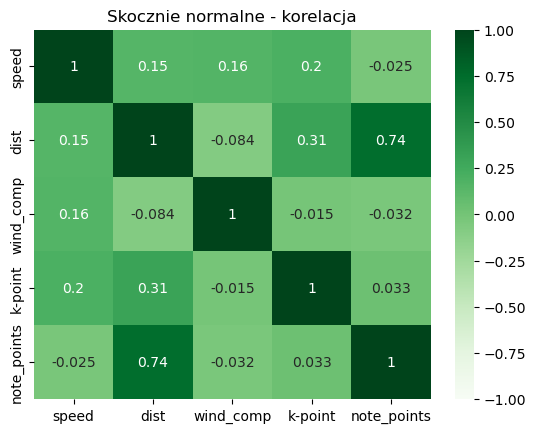

In [86]:
sns.heatmap(normal_hills.corr(), cmap='Greens', annot=True, vmin=-1, vmax=1).set(title="Skocznie normalne - korelacja")

### Skocznie duże

In [87]:
large_hills = lh[['speed', 'dist', 'wind_comp', 'k-point', 'note_points']]

[Text(0.5, 1.0, 'Skocznie duże - korelacja')]

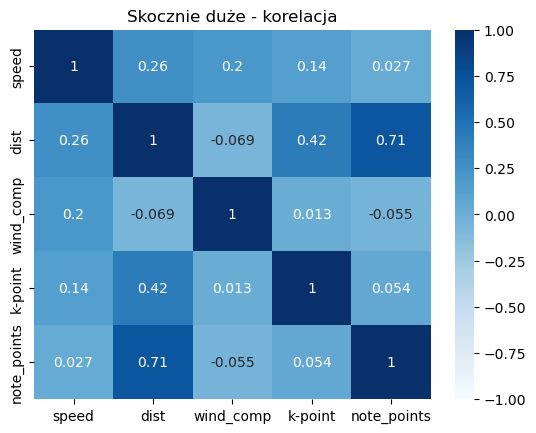

In [88]:
sns.heatmap(large_hills.corr(), cmap='Blues', annot=True, vmin=-1, vmax=1).set(title="Skocznie duże - korelacja")

### Skocznie mamucie

In [89]:
flying_hills = fh[['speed', 'dist', 'wind_comp', 'k-point', 'note_points']]

[Text(0.5, 1.0, 'Skocznie mamucie - korelacja')]

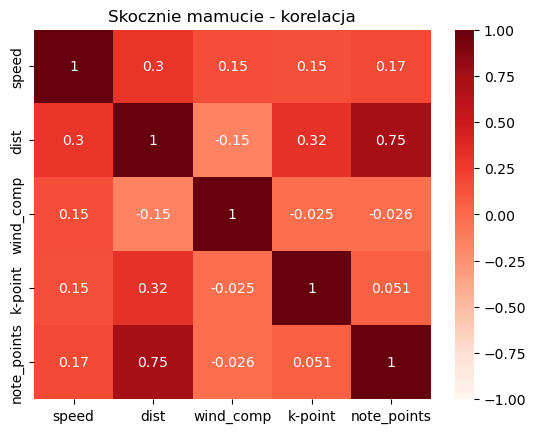

In [90]:
sns.heatmap(flying_hills.corr(), cmap='Reds', annot=True, vmin=-1, vmax=1).set(title="Skocznie mamucie - korelacja")

## Wnioski

Na podstawie macierzy korelacji można zauważyć, że bez względu na rodzaj skoczni istnieje silna zależność pomiędzy odległością uzyskaną
przez zawodników, a notami za styl. Jest to spowodowane tym, że sędziowie oceniając styl sugerują się
odległością i z automatu obniżają noty zawodnikom, którzy nie osiągają punktu konstrukcyjnego.

Inna zależność, jaką można wyczytać to wzrost wpływu wiatru na odległość zawodników w zależności od wielkości skoczni. Co ciekawe, nie jest on duży. Może mieć na to wpływ korekta rozbiegu podczas zawodów, co pozwala na zminimalizowanie wpływu wiatru na zawodników. Największa wartość współczynnik korelacji między wiatrem, a uzyskiwaną odległością występuje dla skoczni mamucich. Ma to odzwierciedlenie w praktyce, ponieważ na skoczniach mamucich wiatr wiejący pod narty daje większą korzyść, niż na skoczniach mniejszych.

## Analiza warunków wietrznych na skoczniach

Wiatr na skoczni odgrywa znaczącą rolę. Nieraz uniemożliwia przeprowadzenie zawodów albo
powoduje, że zawody nie są sprawiedliwe. Z tego powodu wprowadzono przeliczniki wiatrowe, które
starają się rekompensować niekorzystne warunki dla zawodników. Nie są one jednak idealne.

Przeanalizujmy więc, jak zmienny jest wiatr na różnych skoczniach i gdzie konkursy bywają
najbardziej loteryjne.
- z tabeli merged usuniemy konkursy, gdzie nie używano przeliczników
- weźmiemy pod uwagę wind_comp

In [116]:
def wind_analysis(hill, statistic = 'std'):
    """
    hill: rodzaj skoczni. Do wyboru:'normalne', 'duże', 'mamucie'.
    statistic: statystyka, jaką chcemy wyliczyć. Domyślnie std.
    """
    if hill == 'normalne':
        data = nh
    elif hill == 'duże':
        data = lh
    elif hill == 'mamucie':
        data = fh
    cleaned_data = data.dropna(subset = ['wind_comp'])
    cleaned_data = cleaned_data[['wind_comp', 'place']]
    name = "Odchylenie standardowe"
    container = cleaned_data.groupby("place")['wind_comp'].std()
    if statistic == 'mean':
        name = "Średnia arytmetyczna"
        container = cleaned_data.groupby("place")['wind_comp'].mean()
    print(f"Top places:\n {container.sort_values(ascending=False).head()}")
    plt.figure(figsize=(15, 6))
    plt.plot(container)
    plt.title(f"{name} rekompensaty wiatru w różnych lokalizacjach (skocznie {hill})")
    plt.tick_params(axis='x', rotation=90)
    plt.show()

Top places:
 place
Oberwiesenthal (GER)                  9.332661
Kandersteg (SUI)                      9.076842
Courchevel (FRA)                      8.812257
Ljubno ob Savinji (SLO)               8.257902
Utah Olympic Park, Park City (USA)    7.969059
Name: wind_comp, dtype: float64


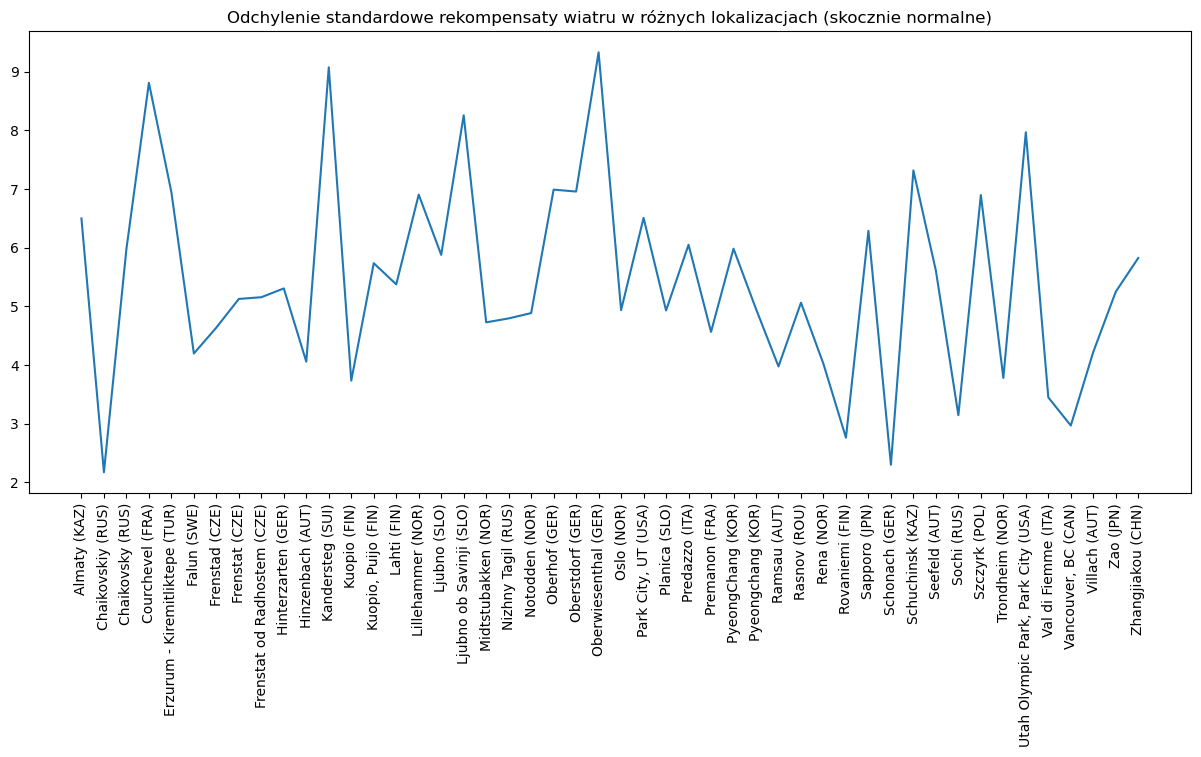

In [121]:
wind_analysis('normalne')

Top places:
 place
Pragelato (ITA)      12.245943
Zhangjiakou (CHN)    11.147480
Predazzo (ITA)       10.190841
Ruka (FIN)           10.063214
Courchevel (FRA)     10.014578
Name: wind_comp, dtype: float64


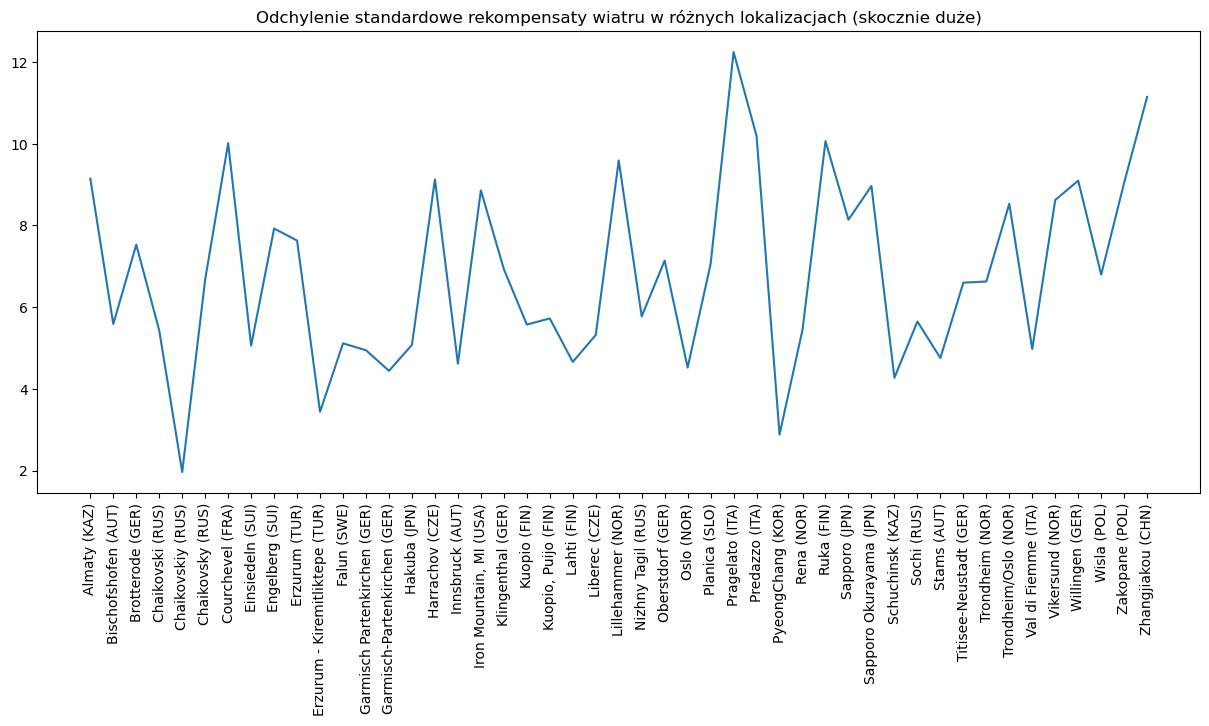

In [122]:
wind_analysis('duże')

Top places:
 place
Vikersund (NOR)                   10.407049
Planica (SLO)                      8.129405
Oberstdorf (GER)                   7.724851
Tauplitz/Bad Mitterndorf (AUT)     7.567924
Harrachov (CZE)                    6.496813
Name: wind_comp, dtype: float64


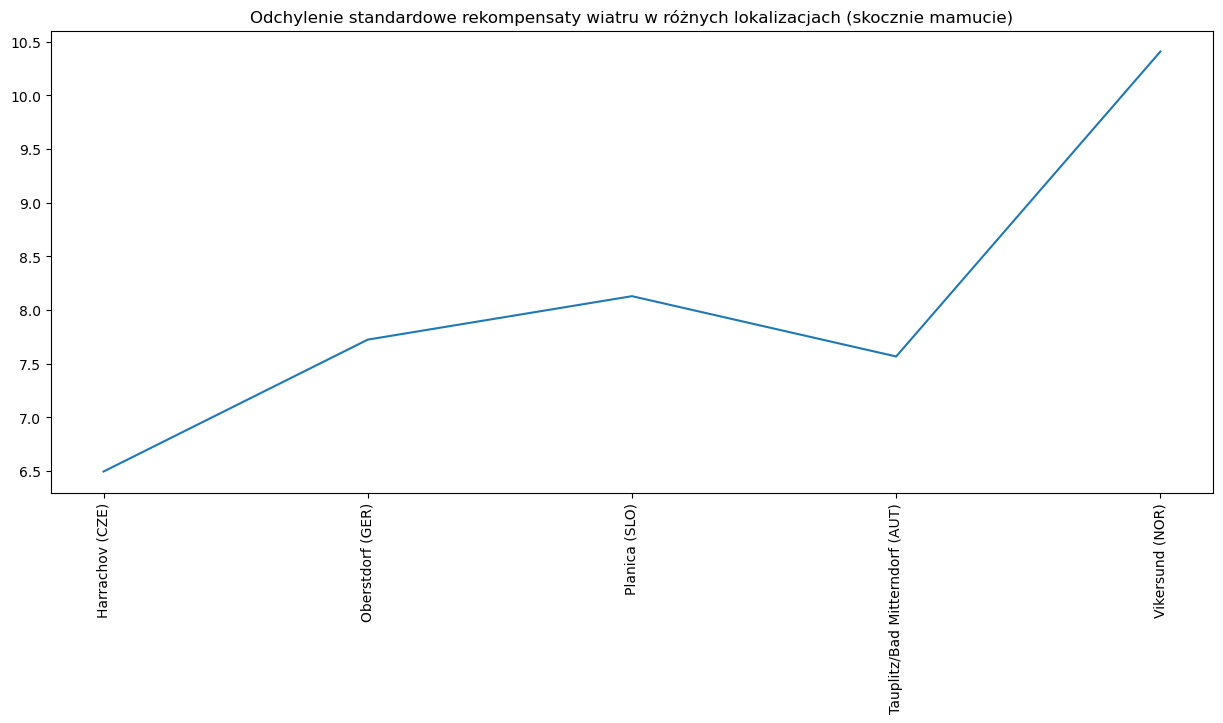

In [123]:
wind_analysis('mamucie')

## Analiza konkretnego skoczka

Wykonamy analizę wyników dla wybranego skoczka
- z połączonego zbioru danych weźmiemy wszystkie jego wyniki
- policzymy stosunek dist/k-point. Na tej podstawie wybierzemy ulubioną skocznię
- później dołączymy jeszcze liczbę skoków za hs w zależności od skoczni

In [139]:
def analyse_skijumper(hill, name):
    """
    hill: rodzaj skoczni. Do wyboru: 'normalne', 'duże', 'mamucie'/
    name: nazwa skoczka w konwencji: 'nazwisko imię'
    """
    if hill == 'normalne':
        data = nh
    elif hill == 'duże':
        data = lh
    elif hill == 'mamucie':
        data = fh
    codex = names[names['name'] == name].iloc[0,1]
    res = data[data['codex_x'] == codex]
    res = res[['dist', 'k-point', 'codex_y', 'place', 'hill_size_x', 'note_points']]
    # res = res.copy()
    res['coef'] = res['dist'] / res['k-point']
    res['hs-jumps'] = res['dist'] >= res['hill_size_x']
    grouped_coefs = res.groupby('place')['coef'].mean()
    hs_jumps = res['hs-jumps'].sum()
    mean_notes = res['note_points'].mean()
    print(f"Ilość skoków za HS: {hs_jumps}")
    print(f"Średnia ocena za styl: {mean_notes:.2f}")
    plt.plot(grouped_coefs)
    plt.tick_params(axis='x', rotation=90)
    plt.show()

## Gregor Schlierenzauer

Ilość skoków za HS: 8
Średnia ocena za styl: 54.55


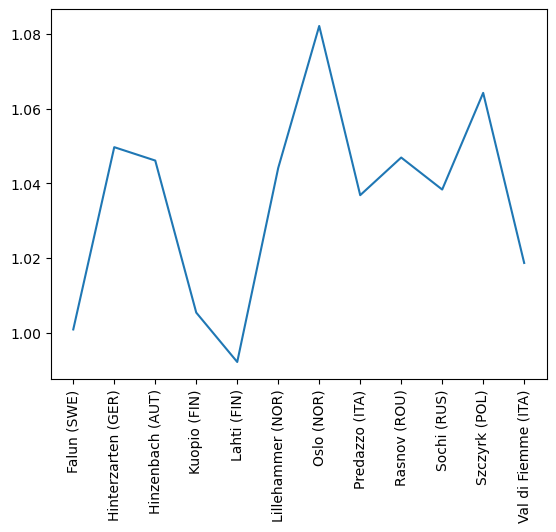

In [140]:
analyse_skijumper('normalne', 'schlierenzauer gregor')

Ilość skoków za HS: 59
Średnia ocena za styl: 54.03


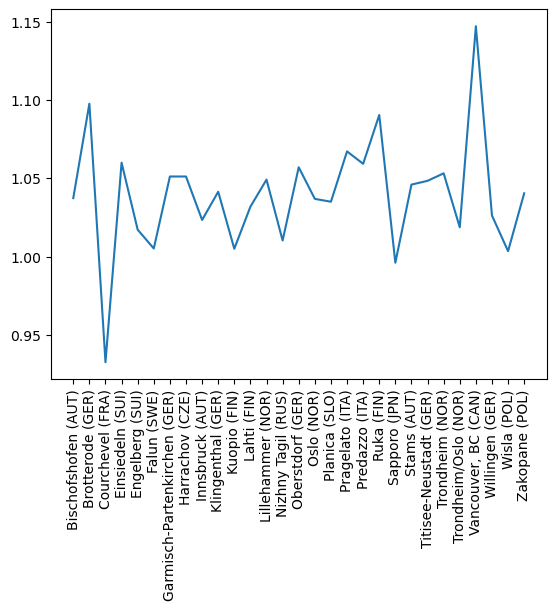

In [141]:
analyse_skijumper('duże', 'schlierenzauer gregor')

Najlepszy średni stosunek między uzyskaną odległością, a punktem konstrukcyjnym Gregor uzyskał w Vancouver (skocznia normalna i skocznia duża liczone razem). No i ma to przełożenie na rzeczywistość, ponieważ w 2009 roku wygrał tam zawody ustanawiając rekord skoczni (149 metrów na skoczni K-125). Rok później podczas igrzysk olimpijskich zdobył tam 2 medale: 1 brązowy indywidualnie i 1 złoty drużynowo.

Ilość skoków za HS: 41
Średnia ocena za styl: 53.33


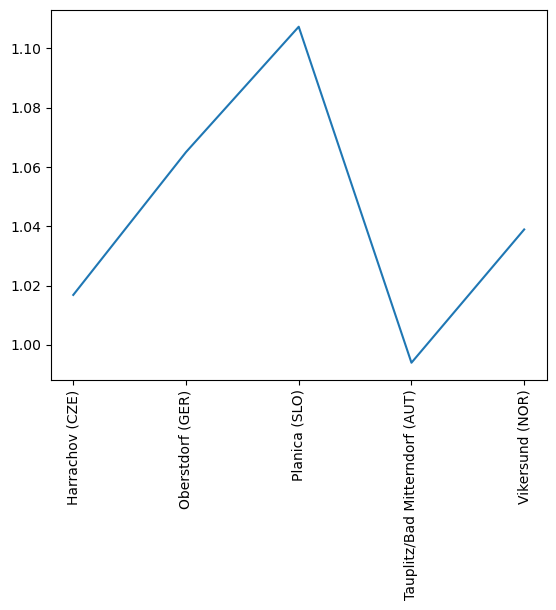

In [142]:
analyse_skijumper('mamucie', 'schlierenzauer gregor')

## Kamil Stoch

Teraz przyjrzyjmy się Polakowi

Ilość skoków za HS: 7
Średnia ocena za styl: 54.11


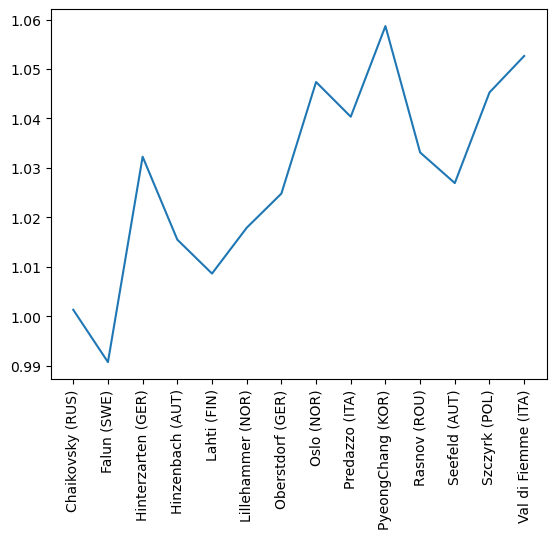

In [143]:
analyse_skijumper('normalne', 'stoch kamil')

Ilość skoków za HS: 105
Średnia ocena za styl: 54.29


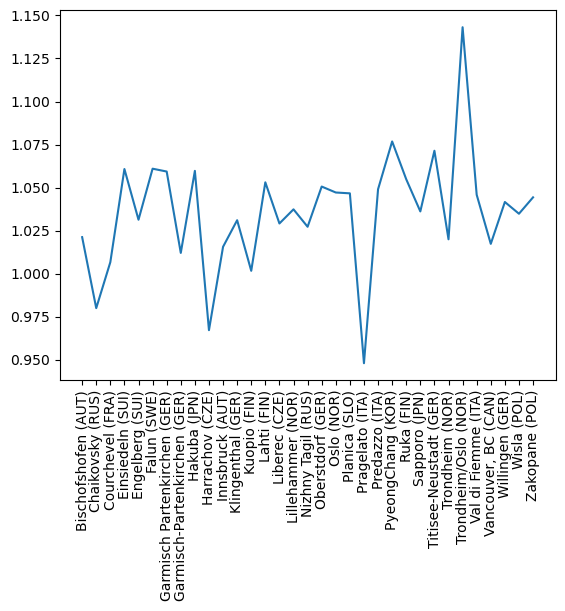

In [144]:
analyse_skijumper('duże', 'stoch kamil')

Ilość skoków za HS: 32
Średnia ocena za styl: 54.42


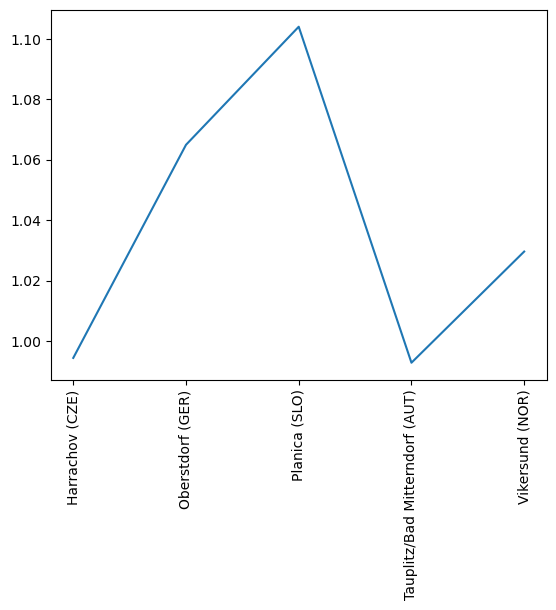

In [145]:
analyse_skijumper('mamucie', 'stoch kamil')

Najlepsze wyniki na mamutach Kamil Stoch uzyskiwał na mamucie w Planicy. Wygrał tam trzykrotnie, najwięcej spośród
innych skoczni mamucich. Najgorsze wyniki uzyskiwał natomiast w Bad Mitterndorf, gdzie nigdy nie wygrał zawodów.